<a href="https://colab.research.google.com/github/kalebsampaco/Tensor-flow-2-completo/blob/master/Collab_12_Crear_una_API_para_Clasificar_Im%C3%A1genes_con_TensorFlow_Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Paso 1: Instalar las dependencias y configurar el proyecto en GPU


In [24]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   159k      0 --:--:-- --:--:-- --:--:--  159k
OK


In [23]:
!apt-get update & apt-get install tensorflow-model-server

Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Reading package lists... Done
Building dependency tree  

In [5]:
!pip install tensorflow-gpu==1.13.1

     |████████████████████████████████| 345.2MB 32kB/s 
     |████████████████████████████████| 368kB 31.9MB/s 
     |████████████████████████████████| 3.2MB 50.9MB/s 
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2


In [1]:
!pip install requests

In [0]:
pip install -q  tfds-nightly matplotlib

## Paso 2: Importar las dependencias del proyecto

In [3]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#from tensorflow.keras.datasets import cifar10
from keras.datasets import cifar10
%matplotlib inline
tf.__version__

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

'1.13.1'

## Paso 3: Pre procesado de los datos

### Cargar el dataset

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
class_names = ['avión', 'coche', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión']

### Normalización de imágenes

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
X_train.shape

(50000, 32, 32, 3)

## Paso 4: Definir el modelo

NOTA: Vamos a usar el mismo modelo que creamos en la Sección de Redes Neuronales Convolucionales

In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


### Compilar el modelo

In [0]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

###  Entrenar el modelo

In [10]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=10)

Epoch 1/10
50000/50000 [==============================] - 9s 186us/sample - loss: 1.5035 - sparse_categorical_accuracy: 0.4566
Epoch 2/10
50000/50000 [==============================] - 4s 72us/sample - loss: 1.0440 - sparse_categorical_accuracy: 0.6324
Epoch 3/10
50000/50000 [==============================] - 4s 73us/sample - loss: 0.8607 - sparse_categorical_accuracy: 0.6970
Epoch 4/10
50000/50000 [==============================] - 4s 72us/sample - loss: 0.7408 - sparse_categorical_accuracy: 0.7435
Epoch 5/10
50000/50000 [==============================] - 4s 72us/sample - loss: 0.6377 - sparse_categorical_accuracy: 0.7776
Epoch 6/10
50000/50000 [==============================] - 4s 72us/sample - loss: 0.5555 - sparse_categorical_accuracy: 0.8073
Epoch 7/10
50000/50000 [==============================] - 4s 72us/sample - loss: 0.4748 - sparse_categorical_accuracy: 0.8343
Epoch 8/10
50000/50000 [==============================] - 4s 72us/sample - loss: 0.4094 - sparse_categorical_accuracy

### Evaluar el modelo

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 81us/sample - loss: 0.9321 - sparse_categorical_accuracy: 0.7475


In [14]:
print("La precisión del modelo es de {} %".format(test_accuracy*100.0))

La precisión del modelo es de 74.75000023841858 %


## Paso 5: Guardar el modelo para subir a producción

### Crear un directorio para el modelo

In [0]:
MODEL_DIR = "model/"
version = 1

In [13]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [0]:
if os.path.isdir(export_path):
    !rm -r {export_path}

### Guardar el modelo para TensorFlow Serving

In [26]:
tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})

AssertionError: ignored

## Paso 6: Configurar el entorno de producción

### Exportar el MODEL_DIR a las variables de entorno

In [0]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

### Ejecutar la API REST de TensorFlow Serving

In [28]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8001 --model_name=cifar10 --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 3 in a separate thread.


In [29]:
!tail server.log

2020-06-10 11:39:55.303645: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:295] Reading SavedModel debug info (if present) from: /content/model/1
2020-06-10 11:39:55.303710: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-06-10 11:39:55.320783: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2020-06-10 11:39:55.348976: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:364] SavedModel load for tags { serve }; Status: success: OK. Took 48409 microseconds.
2020-06-10 11:39:55.350077: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /content/model/1/assets.extra/tf_serving_warmup_requests
2020-06-10 11:39:55.350172: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: cifar10 version: 1}
2020-06-1

## Paso 7: Crear nuestra primera petición por POST

In [30]:
random_image = np.random.randint(0, len(X_test))
random_image

7853

### Crear el objeto de datos en JSON

In [0]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [33]:
data

'{"signature_name": "serving_default", "instances": [[[[0.15294117647058825, 0.15294117647058825, 0.12156862745098039], [0.15294117647058825, 0.15294117647058825, 0.12156862745098039], [0.14901960784313725, 0.14901960784313725, 0.11764705882352941], [0.1450980392156863, 0.1450980392156863, 0.11372549019607843], [0.1411764705882353, 0.1411764705882353, 0.10980392156862745], [0.13725490196078433, 0.1411764705882353, 0.10980392156862745], [0.13725490196078433, 0.1411764705882353, 0.10980392156862745], [0.13725490196078433, 0.1411764705882353, 0.10980392156862745], [0.13725490196078433, 0.1411764705882353, 0.10980392156862745], [0.13333333333333333, 0.13725490196078433, 0.10588235294117647], [0.12941176470588237, 0.13333333333333333, 0.10196078431372549], [0.12941176470588237, 0.13333333333333333, 0.10196078431372549], [0.12941176470588237, 0.13333333333333333, 0.10196078431372549], [0.12941176470588237, 0.13333333333333333, 0.10196078431372549], [0.12941176470588237, 0.13333333333333333, 

### Enviar la primera petición POST al modelo

In [0]:
headers = {"content-type":"application/json"}

In [0]:
json_response = requests.post(url="http://localhost:8001/v1/models/cifar10:predict", data=data, headers=headers)

In [36]:
json_response

<Response [200]>

In [0]:
predictions = json.loads(json_response.text)['predictions']

In [39]:
predictions

[[0.00245063845,
  0.00097004656,
  0.158991858,
  0.666890264,
  0.00222527608,
  0.167271927,
  0.000129486332,
  0.000860854925,
  6.50862262e-07,
  0.000209104473]]

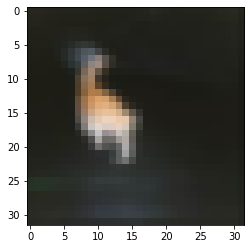

In [40]:
plt.imshow(X_test[random_image])

In [42]:
class_names[np.argmax(predictions[0])]

'gato'

## Paso 8: Enviar una petición POST a un modelo específico 

In [0]:
specific_json_response = requests.post(url="http://localhost:8001/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [44]:
specific_json_response

<Response [200]>